In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [2]:
torch.cuda.device_count()

1

In [3]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()


(16790978560, 17059545088)

In [4]:
torch.cuda.mem_get_info()

(16790978560, 17059545088)

In [5]:
EPOCHS = [10]
LR = [0.00001]
WEIGHT_DECAY = [1e-5]
BATCH_SIZE = [4]
FIRST_DIM = [8]
ENCODE_DIM = [16]
patience = 50

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E' # /groups/francescavitali/eb2/subImages_slide299/H&E

# creating the grid search object
GS = GridSearch( 
       device,
       early_stop_depth = patience,
       epochs=EPOCHS,
       learning_rate=LR,
       weight_decay=WEIGHT_DECAY,
       batch_size = BATCH_SIZE,
       first_dim = FIRST_DIM,
       encode_dim = ENCODE_DIM,
       path= PATH,
       split=[55767, 6971, 6971],
       verbose = 1)

In [ ]:
GS.search()

Starting search with 1 combinations and a early stopping patience of: 50

---Count: 0, Epochs: 10, Weight_Decay: 1e-05, Learning_Rate: 1e-05, Batch_Size: 4---



/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch: 1 | Loss: 0.0138


Epoch: 2 | Loss: 0.0068


Epoch: 3 | Loss: 0.0097


Epoch: 4 | Loss: 0.0070


Epoch: 5 | Loss: 0.0071


Epoch: 6 | Loss: 0.0054


Epoch: 7 | Loss: 0.0077


Epoch: 8 | Loss: 0.0055


Epoch: 9 | Loss: 0.0066



In [3]:
torch.cuda.empty_cache()


In [2]:
PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(PATH, 
                              transform = tensor_transform) #loads the images

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                   [55767, 6971, 6971],
                                                   generator=torch.Generator(device='cpu'))

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                    batch_size = 1,
                                    shuffle = True,
                                    generator=torch.Generator('cpu'))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AE_CNN().to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder

In [4]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0


for (inp, _) in val_loader:
    with torch.no_grad():
        inp = inp.to(device)
        encoded_imgs = encoder(inp)
        encoded_imgs_arr.append(encoded_imgs)
        
        decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - decoded_imgs.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 100 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [5]:
mse_running_total/len(val_loader)

0.00725233965469209

In [10]:
print(f'Not BCE | MSE Average of Complex Model with Dense (8, 16): {mse_running_total/len(img_set)}')

In [6]:
print(f'Not BCE | MSE Average of Complex Model (16, 64): {mse_running_total/len(img_set)}')

In [6]:
print(f'MSE Average of Complex Model (16, 64): {mse_running_total/len(img_set)}')

In [6]:
print(f'MSE Average of Complex Model (64, 128): {mse_running_total/len(img_set)}')

In [28]:
print(f'MSE Average of Model (64, 128): {mse_running_total/len(img_set)}')

In [10]:
mse_running_total = 0
for (img, _) in val_loader:
    with torch.no_grad():

        inp = img.to(device)
        encoded_imgs = encoder(inp)
        decoded = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

In [11]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

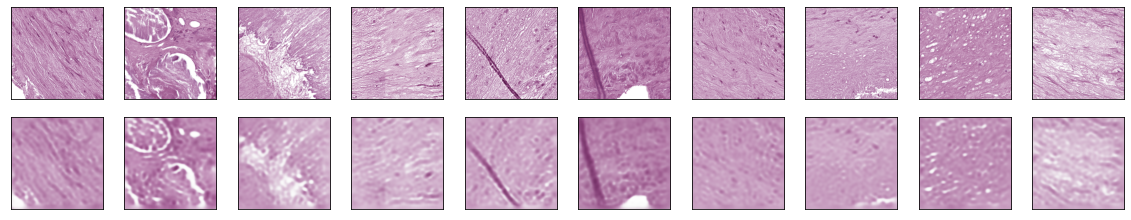

In [6]:
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for i in range(amt):
    k = i
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#     # Compressed states
#     ax = plt.subplot(cols,amt, k+1+amt)
#     plt.gray()
#     img = encoded_imgs_arr[k].detach().cpu().numpy()
#     conv_filter = 0 # [0, 128)
#     plt.imshow(np.transpose(img, (1,2,0))[:,:,conv_filter]) 
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
#     ax = plt.subplot(cols,amt, k+1+2*amt)
#     plt.gray()
#     conv_filter = 60 # [0, 128)
#     plt.imshow(np.transpose(img, (1,2,0))[:,:,conv_filter]) 
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

    # Output States
#     ax = plt.subplot(cols,amt, k+1+3*amt)
#     recon = decoded_imgs_arr[k][1].squeeze()
#     recon = recon.detach().cpu().numpy()
#     plt.imshow(np.transpose(recon, (1,2,0)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [7]:
33*33*64

In [9]:
299*299*3